# Machine Learning Problem Set 2
### Simulations

#### Problem 7

Write a program that generates training data of $n$ i.i.d pairs $D _ { n } = \left\{ \left( X _ { 1 } , Y _ { 1 } \right) , \ldots , \left( X _ { n } , Y _ { n } \right) \right\}$ of random variables where $X$ takes values in  $\mathbb { R } ^ { d }$ and $Y \in \{ 0,1 \}$. The joint distribution is such that $X$ is uniformily distributed in $[ 0,1 ] ^ { d }$ and $\mathbf { P } \{ Y = 1 | X = x \} = x ^ { ( 1 ) }$ where $x ^ { ( 1 ) }$ is the first component of $x = \left( x ^ { ( 1 ) } , \ldots , x ^ { ( d ) } \right)$ 

Classify $X$ using 1,2,5,7,9-nearest neighbor rules. Re-draw $(X,Y)$ many times so that you can estimate the risk of these rules.  Try this for various values of $n$ and $d$ and plot the estimated risk. Explain what you observe. 

Then consider the classification rule that uses an additional set of $m$ independent data $D _ { m } ^ { \prime } = \left\{ \left( X _ { 1 } ^ { \prime } , Y _ { 1 } ^ { \prime } \right) , \ldots , \left( X _ { m } ^ { \prime } , Y _ { m } ^ { \prime } \right) \right\}$ drawn from the same distribution to select the value of $k \in \{ 1,3,5,7,9 \}$ in the $k$-nearest neighbot rule (trained on the data $D_n$) using empirical risk minimization based on $D _ { m } ^ { \prime }$. Estimate the probability of error of this rule (using independent test data) and compare it to the probability of error of the best of these five classification rules. How large does $m$ have to be to make sure that the data/based selection is close to optimal?

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
import itertools
from multiprocessing import Pool

For the DGP we need to generate (X,y) pairs, since sklearn-knn uses knn.fit(X,y) to "fit" the model. 

In [2]:
# Define Data Generation
def generate_data(n,d):
    X = np.random.uniform(0,1,n*d).reshape(n,d)
    
    # Random version
    y = [np.random.binomial(1,p=x[0]) for x in X]
    
    return (X, y)

In [3]:
class bayes_classifier:
    
    def __init__(self,boundary):
        self.boundary = boundary
    
    def fit(self,X,y):
        pass
        
    def predict(self,X):
        prediction = [1 if x[0] >= self.boundary else 0 for x in X ]
        return(prediction)

In [12]:
# Define the classifiers
bayes = bayes_classifier(boundary= 0.5)
knn1 = KNeighborsClassifier(n_neighbors=1)
knn3 = KNeighborsClassifier(n_neighbors=3)
knn5 = KNeighborsClassifier(n_neighbors=5)
knn7 = KNeighborsClassifier(n_neighbors=7)
knn9 = KNeighborsClassifier(n_neighbors=9)

classifiers = [bayes, knn1, knn3, knn5, knn7, knn9]

classifier_names = ['Bayes','1-NN', '3-NN', '5-NN', '7-NN', '9-NN']

We now estimate the risk of each classifier. The empirical risk is defined as 

$$R_n(g) = \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{g(x) \neq y}$$

which is nothing more than one minus the accuracy. (Should be on the training set, use cross validation?). 

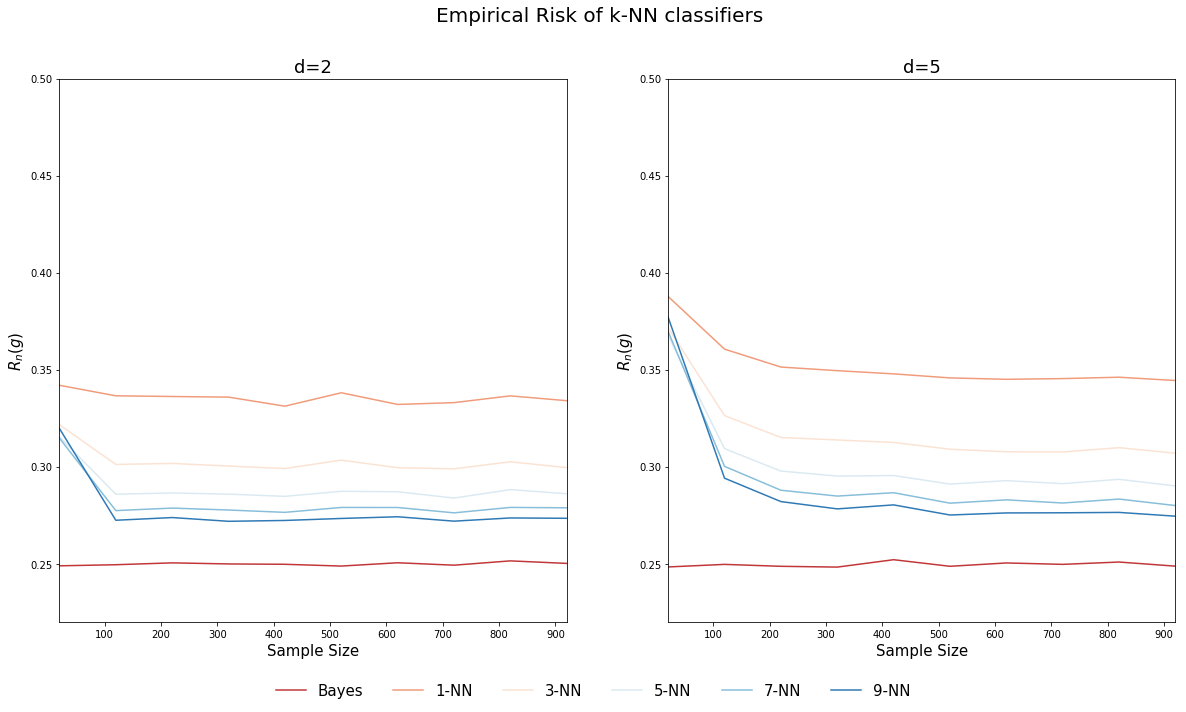

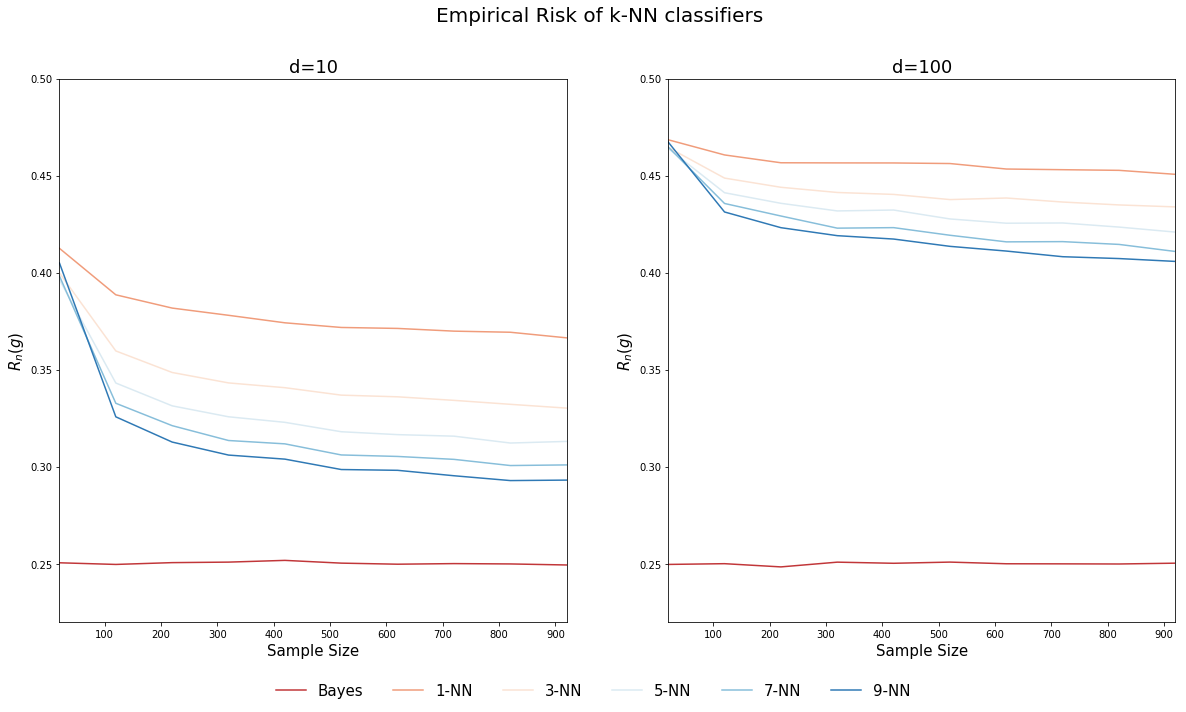

In [14]:
# Varying sample sizes
sample_sizes = np.arange(20,1000,100)

# Dimensions
dims_to_plot = [[2,5],[10,100]]

# Rounds per sample size
rounds = 200

# Testing size
testing_n = 1000

# Setting up colors for the plot
colors = sns.color_palette("RdBu",n_colors=len(classifiers))

for dimensions in dims_to_plot:
    
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10))

    for i in range(0,len(dimensions)):
        
        # Current Dimension
        d = dimensions[i]
        
        # Array for storing accuracy scores per dimension.
        accuracy = np.array([], dtype=np.int64).reshape(0,len(classifiers))
    
        for n in sample_sizes:
    
            accuracy_temp = []
    
            for r in range(rounds):
    
                # Temporary arry for accuracy
                temp = []
    
                # "Training" data on which we fit on
                X, y = generate_data(n,d)

                # Generate larger sample on which we get our accuracy
                testing_X, testing_y = generate_data(testing_n,d)
            
                for classifier in classifiers:
            
                    classifier.fit(X,y)
    
                    predictions = classifier.predict(testing_X)
    
                    temp.append(1-accuracy_score(testing_y,predictions))
        
                accuracy_temp.append(temp)
        
            mean_accuracy = np.mean(accuracy_temp,axis=0)
        
            accuracy = np.concatenate((accuracy,[mean_accuracy]), axis = 0)
    
        for j in range(0,len(classifiers)):
            sns.lineplot(x= sample_sizes, y =accuracy[:,j], ax= ax[i], color = colors[j])
            ax[i].set_title(f"d={dimensions[i]}",fontsize = 18,fontweight = 100)

    for a in ax:
        a.set_xlabel("Sample Size",fontsize=15)
        a.set_ylabel("$R_n(g)$",fontsize=15)
        a.set_ylim(bottom = 0.22, top  =0.5)
        a.set_xlim(left=sample_sizes[0], right = sample_sizes[-1])
    
    
    fig.legend(classifier_names,frameon=False,
               fontsize = 15,loc = 8,ncol = len(classifiers))
            
    fig.suptitle("Empirical Risk of k-NN classifiers",fontsize = 20);
    fig.savefig(f"../01_Figures/Emp_Risk_d_{dimensions[0]}_{dimensions[1]}", dpi=80)

Now consider the classification rule that uses and additional set of $m$ independent data $D _ { m } ^ { \prime } = \left\{ \left( X _ { 1 } ^ { \prime } , Y _ { 1 } ^ { \prime } \right) , \ldots , \left( X _ { m } ^ { \prime } , Y _ { m } ^ { \prime } \right) \right\}$ drawn from the same distribution to select the value of $k \in \{ 1,3,5,7,9 \}$. Train the data on $D_n$ and select the classifier based on empirical risk minimization on the set $D_m$.  Finally draw many new samples to get the out of sample risk of the final classifier.  How large does $m$ have to be to make sure that the databased selection is close to optimal?

In [22]:
def simulate(n,d,rounds,testing_n,validation_sizes):
    
    # Define Classifiers
    knn1 = KNeighborsClassifier(n_neighbors=1)
    knn3 = KNeighborsClassifier(n_neighbors=3)
    knn5 = KNeighborsClassifier(n_neighbors=5)
    knn7 = KNeighborsClassifier(n_neighbors=7)
    knn9 = KNeighborsClassifier(n_neighbors=9)

    # Store in list to loop over
    classifiers = [knn1, knn3, knn5, knn7, knn9]

    # Set up for plot and storing results
    classifier_names = ['1-NN', '3-NN', '5-NN', '7-NN', '9-NN']
    
    # Dataframe for storing the results
    columns_df = classifier_names + ['Risk CV', 'Risk 9-NN']
    results = pd.DataFrame(np.nan, index=validation_sizes, columns= columns_df)

    # Results to plot
    to_plot1 = ["Risk CV",'Risk 9-NN']
    to_plot2 = ['1-NN', '3-NN', '5-NN', '7-NN', '9-NN']

    # Simulation
    for m in validation_sizes:
        
        # Array to store risk at point m
        m_temp = []
    
        # Array to store risk of 9-nn classifier
        knn9_risk = []
    
        # Choosen classifier
        choosen_Classifier = []
    
        for r in range(rounds):

            # Draw data n (training data)
            X_n, y_n = generate_data(n,d)

            # Draw data m (validation data)
            X_m, y_m = generate_data(m,d)

            # Final testing data
            testing_X, testing_y = generate_data(testing_n,d)

            # Temp to store risk -> For later choosing min risk classifier
            temp = []

            for classifier in classifiers:
    
                # Fit on training set X_n, y_n
                classifier.fit(X_n,y_n)
    
                # Get score on testing set X_m, y_m
                temp.append(1-classifier.score(X_m,y_m))
    
            # Choose minimum risk classifier based on out of sample risk minimization
            classifierCv = classifiers[temp.index(min(temp))]

            # Store name of the choice 
            choosen_Classifier.append(classifier_names[temp.index(min(temp))])

            # Estimate risk of the rule based on the independent test data
            m_temp.append(1-classifierCv.score(testing_X,testing_y))
        
            # Same for 9-nn for comparing as optimum
            knn9.fit(X_n,y_n)
        
            knn9_risk.append(1-knn9.score(testing_X,testing_y))
        
        # Count choices  
        m_result =  [choosen_Classifier.count(knn)/rounds for knn in classifier_names]
    
        # Append other results
        m_result.extend((np.round(np.mean(m_temp),5),np.round(np.mean(knn9_risk),5)))
    
        # Store results in df 
        results.loc[m,:] = m_result 

    # Plot the results for current values
    fig, ax = plt.subplots(nrows= 1, ncols=2,figsize=(20,10))

    # Risk of cross-validation rule and 9-nn
    sns.lineplot(data=results[to_plot1], palette= "RdBu", dashes =  False,ax=ax[0])
    ax[0].legend(to_plot1,frameon=True, fontsize = 15,loc = 1,ncol = len(to_plot1))
    ax[0].set_title("Risk of Rule Based Classifier and 9-NN",fontsize = 18,fontweight = 100)
    ax[0].set_ylabel("$R_n(g)$",fontsize=15)
    ax[0].set_ylim(bottom = 0.25, top  =0.35)
    ax[0].set_xlim(left=validation_sizes[0], right = validation_sizes[-1])


    # Choices as percent of rounds 
    sns.lineplot(data =results[to_plot2], palette= "RdBu", dashes=False, ax= ax[1])
    ax[1].legend(to_plot2,frameon=True, fontsize = 14,loc = 1,ncol = len(to_plot2))
    ax[1].set_title("Choice of k in Rule Based Classifier",fontsize = 18,fontweight = 100)
    ax[1].set_ylabel("Frequency of Choice of Classifier", fontsize = 15)
    ax[1].set_xlim(left=validation_sizes[0], right = validation_sizes[-1])
    ax[1].set_ylim(bottom=0,top = 1)
    
    for a in ax:
        a.set_xlabel("Validation Size $m$",fontsize=15)
    
    fig.suptitle(f"$D_n$ = {n}, Dimension = {d}",fontsize = 20);
    fig.savefig(f"../01_Figures/CV_KNN_n{n}_d{d}", dpi=80)

In [23]:
%%time
# Simulate in parallel

# Simulation rounds
rounds = 500

# set sample sizes and dimensions to simulate
sample_sizes_n = [100,500]
dimensions = [2,10]

# Combine the two to iterate over
combinations = list(itertools.product(sample_sizes_n, dimensions))

# Sizes of the cross validation sample
validation_sizes = np.arange(20,2000,200)

# Sample size for indenpendent testing sample 
testing_n = 2000

# Execute in Parallel
pool = Pool(processes=4)

# Submit jobs in parallel
results = [pool.apply_async(simulate, args=(comb[0],comb[1],rounds,testing_n,validation_sizes)) for comb in combinations]

output = [p.get() for p in results]
print(output)
pool.close()


[None, None, None, None]
CPU times: user 1.19 s, sys: 536 ms, total: 1.73 s
Wall time: 15min 26s
